In [1]:
import sys
import os
sys.path.append("/work/ariyanzarei/SorghumSegmentation/SorghumPartNet/")
from models.extensions import *
from models.leaf_model import *
from train_and_inference.predict_and_visualize import load_model
from data.load_raw_data import load_pcd_plyfile
from data.utils import create_ply_pcd_from_points_with_labels
import torch
import open3d as o3d
from torch.autograd import gradcheck
from torchcluster.zoo.spectrum import SpectrumClustering

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


In [2]:
instance_model = load_model("SorghumPartNetInstance",0)
semantic_model = load_model("SorghumPartNetSemantic",0)

path = f"/space/ariyanzarei/sorghum_segmentation/dataset/2022-03-10/PointCloud/{452}.ply"
pcd = load_pcd_plyfile(path)
points = torch.tensor(pcd['points'], requires_grad=True, dtype=torch.float)
points_full = torch.Tensor(pcd['points_full'])

point_features = instance_model(points.unsqueeze(0).to(torch.device('cuda')))
point_semantics = semantic_model(points.unsqueeze(0).to(torch.device('cuda')))

clusters = Cluster.apply(point_features,5)
# ply = create_ply_pcd_from_points_with_labels(points, clusters.squeeze())

Using  epoch=9-step=9379.ckpt
Using  epoch=16-step=31874.ckpt


In [3]:
def load_model_chkpoint(model,path):
    model = eval(model).load_from_checkpoint(path)
    model = model.cuda()
    model.eval()
    return model

In [4]:
leaf_classifier = load_model_chkpoint("SorghumPartNetLeaf","/space/murph186/sorghum_segmentation/models/model_checkpoints/leaf_net_2022_03_10_v1/lightning_logs/version_2/checkpoints/epoch=18-step=22800.ckpt")
input = points.unsqueeze(0).cuda()
branch_model = LeafBranch(5, leaf_classifier)
losses = branch_model(point_features, input)
print(losses)

args(k=15, num_points=80)
tensor([27.8025], grad_fn=<LeafBranchFuncBackward>)


/work/ariyanzarei/SorghumSegmentation/SorghumPartNet/models/extensions.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  leaf_cls = torch.nn.functional.softmax(


In [5]:
points.retain_grad()
point_features.retain_grad()
losses.backward()

In [6]:
# print(point_features.is_leaf)
# point_features = point_features.detach()
# print(points.grad)
# print(point_features.grad)
# print(points)
# print(clusters)
point_semantics = torch.argmax(point_semantics.T,1)
print(point_semantics)
print(point_semantics.shape)

tensor([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0')
torch.Size([8000, 1])


In [55]:
import matplotlib.pyplot as plt
import math
import numpy as np
%matplotlib widget

def plot_leaf(points, clusters, grads, segment_label):
  min_color = np.min(grads)
  max_color = np.max(grads)
  unique_clusters = clusters[segment_label==1].unique()
  fig = plt.figure(figsize=(15, 50))
  fig2 = plt.figure(figsize=(15,10))
  ax2 = fig2.add_subplot(1,2,1, projection='3d')
  ax3 = fig2.add_subplot(1,2,2, projection='3d')
  figure_counts = len(unique_clusters)  
  min_, max_ = grads.min(), grads.max()
  norm = plt.Normalize(vmin=min_, vmax=max_)
  cmap = plt.cm.RdYlGn
  for i, c in enumerate(unique_clusters):
    ax = fig.add_subplot(int(math.ceil(figure_counts/3)), 3, i+1, projection='3d')
    cluster_points = points[torch.logical_and(clusters==c,segment_label==1)]
    cluster_grads = grads[torch.logical_and(clusters==c,segment_label==1)]
    # cluster_color = (cluster_grads[0,0]-min_color)/(max_color-min_color)
    cluster_color = cluster_grads[0,0]
    cluster_color = np.full(cluster_points[:,1].shape[0],cluster_color)
    # cluster_color[:,1:] = 0
    ax.scatter(cluster_points[:,0],cluster_points[:,2],cluster_points[:,1],c=cluster_color, norm=norm, cmap=cmap)
    ax2.scatter(cluster_points[:,0],cluster_points[:,2],cluster_points[:,1])
    mappable = ax3.scatter(cluster_points[:,0],cluster_points[:,2],cluster_points[:,1],c=cluster_color, norm=norm, cmap=cmap)
    ax.set_title(f"grad: {cluster_grads[0,0]:2.2f}")
  fig2.colorbar(mappable,ax=ax3)
  # plt.show()


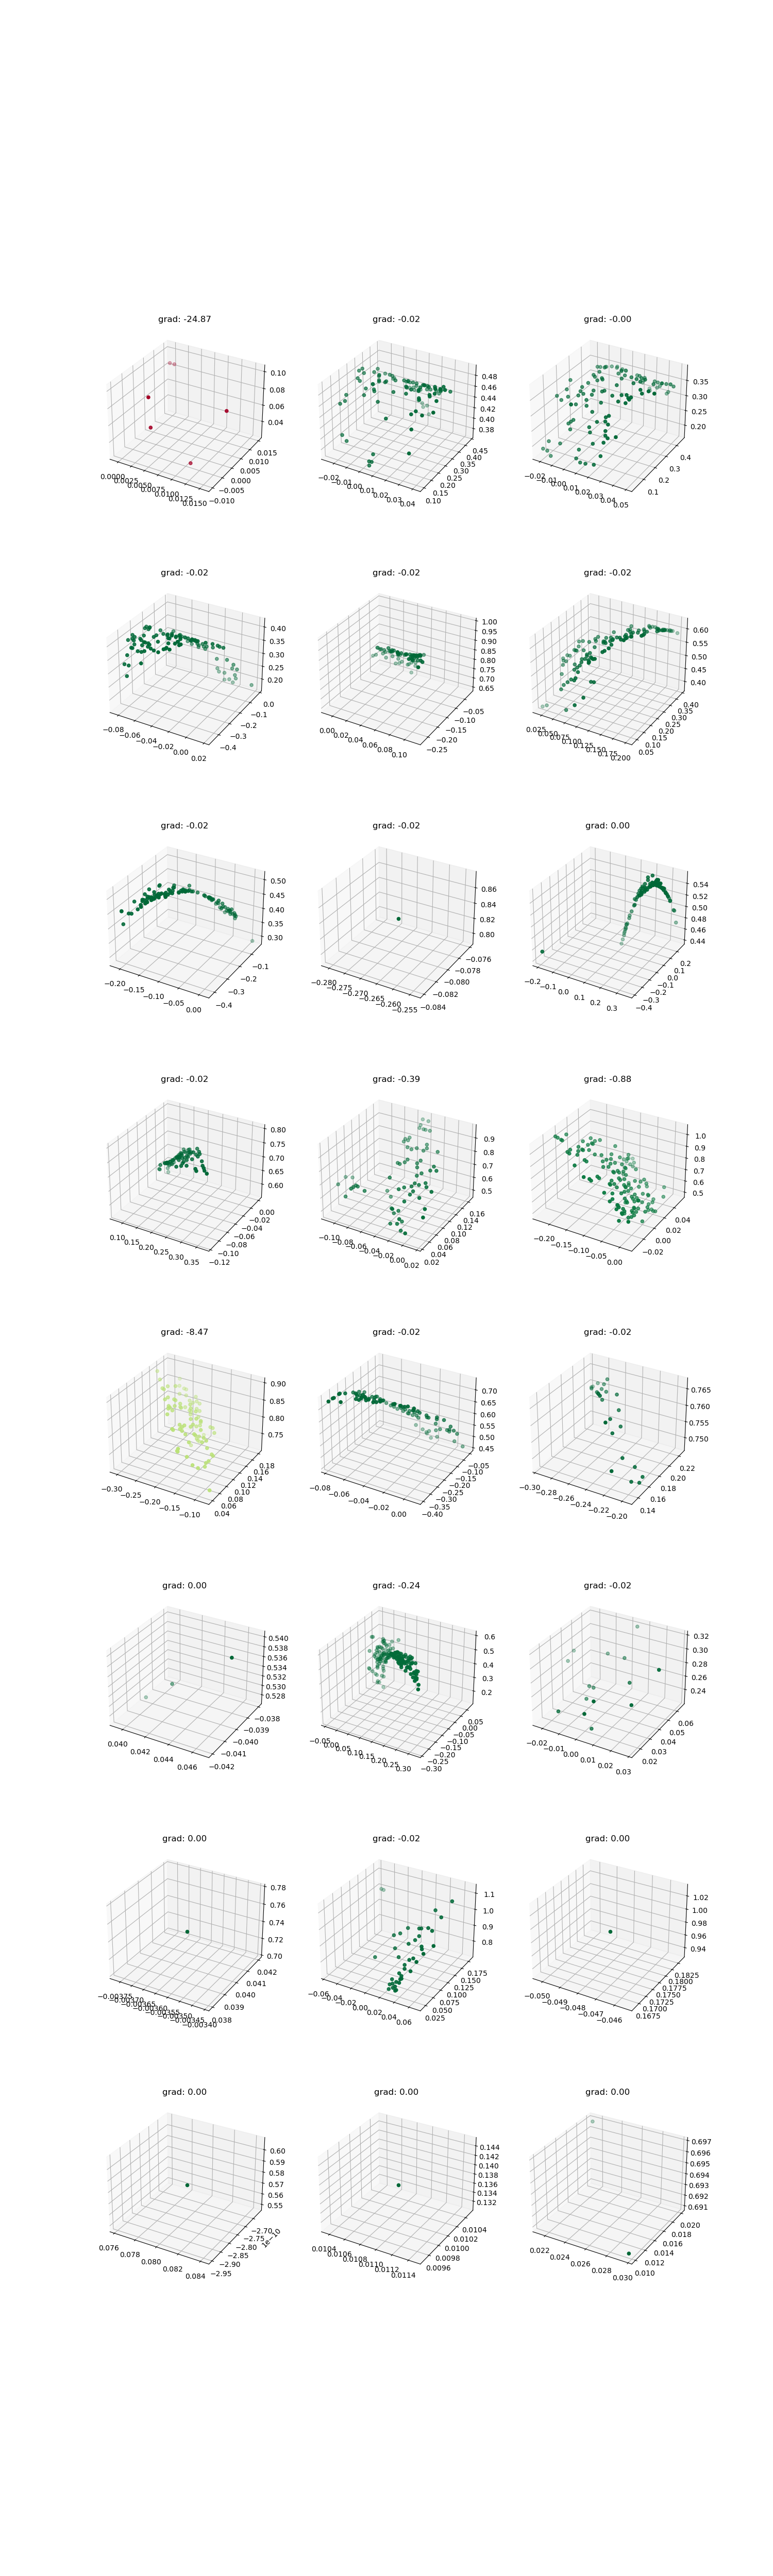

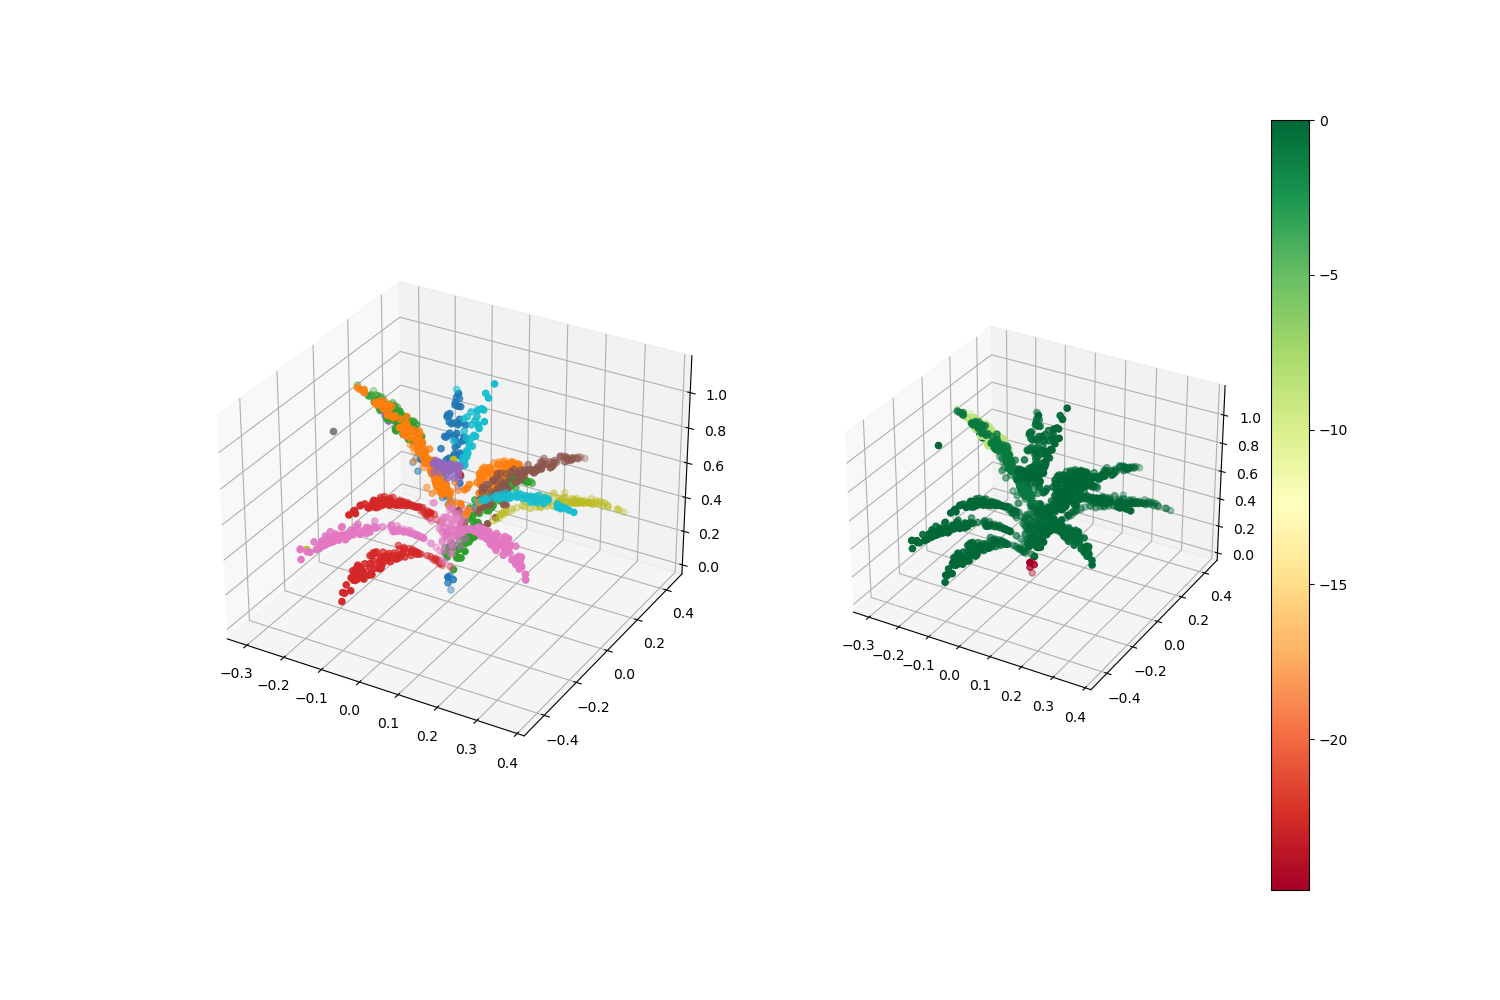

In [56]:
plot_leaf(points.detach().numpy(),clusters.squeeze(),point_features.grad.nan_to_num(0).squeeze().cpu().detach().numpy(),point_semantics.squeeze().cpu())